# ***Replica Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [8]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 24000
# The MSI sample type for filtering
SAMPLE_TYPE = "r"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [3]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [4]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      file_names.append(msi_row.file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [03:05<00:00,  7.71s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [5]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

In [7]:
mzs, _ =  parsers["HG 10-r"].getspectrum(0)
mzs_filter = (mzs >= 600) & (mzs <= 900)

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [9]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra[mzs_filter], labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [10]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [11]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
126/126 [==============================] - 38s 283ms/step - loss: 0.1891 - binary_accuracy: 0.9259 - val_loss: 0.6962 - val_binary_accuracy: 0.6165
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/100
126/126 [==============================] - 26s 203ms/step - loss: 0.0631 - binary_accuracy: 0.9788 - val_loss: 0.6625 - val_binary_accuracy: 0.6165
Epoch 3/100
126/126 [==============================] - 26s 208ms/step - loss: 0.0413 - binary_accuracy: 0.9866 - val_loss: 0.5042 - val_binary_accuracy: 0.8010
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 4/100
126/126 [==============================] - 26s 204ms/step - loss: 0.0279 - binary_accuracy: 0.9907 - val_loss: 0.3202 - val_binary_accuracy: 0.8979
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 5/100
126/126 [===

  5%|▍         | 1/22 [09:25<3:18:05, 565.97s/it]

##############################
Epoch 1/100
125/125 [==============================] - 32s 247ms/step - loss: 0.1908 - binary_accuracy: 0.9249 - val_loss: 0.6999 - val_binary_accuracy: 0.5457
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/100
125/125 [==============================] - 27s 214ms/step - loss: 0.0534 - binary_accuracy: 0.9811 - val_loss: 0.7259 - val_binary_accuracy: 0.4543
Epoch 3/100
125/125 [==============================] - 27s 215ms/step - loss: 0.0320 - binary_accuracy: 0.9893 - val_loss: 0.9736 - val_binary_accuracy: 0.4543
Epoch 4/100
125/125 [==============================] - 26s 211ms/step - loss: 0.0215 - binary_accuracy: 0.9924 - val_loss: 0.5489 - val_binary_accuracy: 0.6840
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 5/100
125/125 [==============================] - 27s 216ms/step - loss: 0.0221 - binary_accuracy: 0

  9%|▉         | 2/22 [16:44<2:43:38, 490.94s/it]

##############################
Epoch 1/100
132/132 [==============================] - 32s 236ms/step - loss: 0.2127 - binary_accuracy: 0.9135 - val_loss: 0.6804 - val_binary_accuracy: 0.5710
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/100
132/132 [==============================] - 30s 224ms/step - loss: 0.0646 - binary_accuracy: 0.9770 - val_loss: 0.7168 - val_binary_accuracy: 0.4290
Epoch 3/100
132/132 [==============================] - 29s 219ms/step - loss: 0.0368 - binary_accuracy: 0.9878 - val_loss: 0.8654 - val_binary_accuracy: 0.4294
Epoch 4/100
132/132 [==============================] - 30s 228ms/step - loss: 0.0233 - binary_accuracy: 0.9919 - val_loss: 0.3519 - val_binary_accuracy: 0.8408
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 5/100
132/132 [==============================] - 30s 227ms/step - loss: 0.0231 - binary_accuracy: 0

 14%|█▎        | 3/22 [22:47<2:17:00, 432.66s/it]

##############################
Epoch 1/100
131/131 [==============================] - 29s 217ms/step - loss: 0.2118 - binary_accuracy: 0.9162 - val_loss: 0.6791 - val_binary_accuracy: 0.5664
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/100
131/131 [==============================] - 28s 212ms/step - loss: 0.0552 - binary_accuracy: 0.9800 - val_loss: 0.8140 - val_binary_accuracy: 0.4336
Epoch 3/100
131/131 [==============================] - 28s 217ms/step - loss: 0.0319 - binary_accuracy: 0.9885 - val_loss: 0.9291 - val_binary_accuracy: 0.4352
Epoch 4/100
131/131 [==============================] - 28s 216ms/step - loss: 0.0257 - binary_accuracy: 0.9906 - val_loss: 0.3704 - val_binary_accuracy: 0.8211
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 5/100
131/131 [==============================] - 28s 211ms/step - loss: 0.0209 - binary_accuracy: 0

 18%|█▊        | 4/22 [30:29<2:13:13, 444.09s/it]

##############################
Epoch 1/100
130/130 [==============================] - 29s 220ms/step - loss: 0.2155 - binary_accuracy: 0.9104 - val_loss: 0.6809 - val_binary_accuracy: 0.5646
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/100
130/130 [==============================] - 28s 217ms/step - loss: 0.0588 - binary_accuracy: 0.9784 - val_loss: 0.7497 - val_binary_accuracy: 0.4354
Epoch 3/100
130/130 [==============================] - 28s 216ms/step - loss: 0.0349 - binary_accuracy: 0.9887 - val_loss: 0.7359 - val_binary_accuracy: 0.4396
Epoch 4/100
130/130 [==============================] - 29s 221ms/step - loss: 0.0262 - binary_accuracy: 0.9916 - val_loss: 0.3272 - val_binary_accuracy: 0.8724
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 5/100
130/130 [==============================] - 28s 218ms/step - loss: 0.0199 - binary_accuracy: 0

 23%|██▎       | 5/22 [36:21<1:56:26, 410.97s/it]

##############################
Epoch 1/100
131/131 [==============================] - 29s 218ms/step - loss: 0.2025 - binary_accuracy: 0.9177 - val_loss: 0.6844 - val_binary_accuracy: 0.5665
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/100
131/131 [==============================] - 29s 219ms/step - loss: 0.0582 - binary_accuracy: 0.9788 - val_loss: 0.7402 - val_binary_accuracy: 0.4335
Epoch 3/100
131/131 [==============================] - 29s 221ms/step - loss: 0.0340 - binary_accuracy: 0.9877 - val_loss: 0.8462 - val_binary_accuracy: 0.4360
Epoch 4/100
131/131 [==============================] - 28s 217ms/step - loss: 0.0308 - binary_accuracy: 0.9896 - val_loss: 0.2519 - val_binary_accuracy: 0.9253
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 5/100
131/131 [==============================] - 28s 216ms/step - loss: 0.0240 - binary_accuracy: 0

 27%|██▋       | 6/22 [43:16<1:49:55, 412.22s/it]

##############################
Epoch 1/100
126/126 [==============================] - 29s 221ms/step - loss: 0.2111 - binary_accuracy: 0.9142 - val_loss: 0.6848 - val_binary_accuracy: 0.5484
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/100
126/126 [==============================] - 28s 220ms/step - loss: 0.0666 - binary_accuracy: 0.9763 - val_loss: 0.7468 - val_binary_accuracy: 0.4516
Epoch 3/100
126/126 [==============================] - 27s 218ms/step - loss: 0.0383 - binary_accuracy: 0.9866 - val_loss: 0.8389 - val_binary_accuracy: 0.4521
Epoch 4/100
126/126 [==============================] - 28s 219ms/step - loss: 0.0286 - binary_accuracy: 0.9898 - val_loss: 0.4284 - val_binary_accuracy: 0.6982
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 5/100
126/126 [==============================] - 26s 208ms/step - loss: 0.0218 - binary_accuracy: 0

 32%|███▏      | 7/22 [49:03<1:37:46, 391.08s/it]

##############################
Epoch 1/100
130/130 [==============================] - 30s 224ms/step - loss: 0.2093 - binary_accuracy: 0.9153 - val_loss: 0.6804 - val_binary_accuracy: 0.5625
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/100
130/130 [==============================] - 28s 214ms/step - loss: 0.0561 - binary_accuracy: 0.9809 - val_loss: 0.9655 - val_binary_accuracy: 0.4375
Epoch 3/100
130/130 [==============================] - 29s 218ms/step - loss: 0.0357 - binary_accuracy: 0.9869 - val_loss: 1.0518 - val_binary_accuracy: 0.4381
Epoch 4/100
130/130 [==============================] - 30s 228ms/step - loss: 0.0283 - binary_accuracy: 0.9903 - val_loss: 0.5443 - val_binary_accuracy: 0.6812
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 5/100
130/130 [==============================] - 29s 222ms/step - loss: 0.0216 - binary_accuracy: 0

 36%|███▋      | 8/22 [55:55<1:32:46, 397.60s/it]

##############################
Epoch 1/100
128/128 [==============================] - 29s 222ms/step - loss: 0.2201 - binary_accuracy: 0.9104 - val_loss: 0.6906 - val_binary_accuracy: 0.5555
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/100
128/128 [==============================] - 28s 220ms/step - loss: 0.0598 - binary_accuracy: 0.9788 - val_loss: 0.6555 - val_binary_accuracy: 0.6408
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 3/100
128/128 [==============================] - 28s 218ms/step - loss: 0.0355 - binary_accuracy: 0.9878 - val_loss: 0.5594 - val_binary_accuracy: 0.5710
Epoch 4/100
128/128 [==============================] - 28s 220ms/step - loss: 0.0252 - binary_accuracy: 0.9913 - val_loss: 0.2124 - val_binary_accuracy: 0.9491
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 41%|████      | 9/22 [1:02:47<1:27:07, 402.14s/it]

##############################
Epoch 1/100
132/132 [==============================] - 30s 223ms/step - loss: 0.2083 - binary_accuracy: 0.9177 - val_loss: 0.6820 - val_binary_accuracy: 0.5690
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/100
132/132 [==============================] - 30s 223ms/step - loss: 0.0592 - binary_accuracy: 0.9797 - val_loss: 0.7984 - val_binary_accuracy: 0.4310
Epoch 3/100
132/132 [==============================] - 30s 226ms/step - loss: 0.0333 - binary_accuracy: 0.9880 - val_loss: 0.9462 - val_binary_accuracy: 0.4316
Epoch 4/100
132/132 [==============================] - 29s 219ms/step - loss: 0.0250 - binary_accuracy: 0.9907 - val_loss: 0.3845 - val_binary_accuracy: 0.7661
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 5/100
132/132 [==============================] - 28s 215ms/step - loss: 0.0240 - binary_accuracy:

 45%|████▌     | 10/22 [1:08:56<1:18:21, 391.79s/it]

##############################
Epoch 1/100
131/131 [==============================] - 30s 223ms/step - loss: 0.2046 - binary_accuracy: 0.9161 - val_loss: 0.6808 - val_binary_accuracy: 0.5658
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/100
131/131 [==============================] - 30s 226ms/step - loss: 0.0549 - binary_accuracy: 0.9808 - val_loss: 0.7806 - val_binary_accuracy: 0.4342
Epoch 3/100
131/131 [==============================] - 29s 221ms/step - loss: 0.0343 - binary_accuracy: 0.9887 - val_loss: 0.9747 - val_binary_accuracy: 0.4345
Epoch 4/100
131/131 [==============================] - 30s 226ms/step - loss: 0.0273 - binary_accuracy: 0.9902 - val_loss: 0.6622 - val_binary_accuracy: 0.6996
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 5/100
131/131 [==============================] - 29s 219ms/step - loss: 0.0242 - binary_accuracy:

 50%|█████     | 11/22 [1:15:57<1:13:28, 400.74s/it]

##############################
Epoch 1/100
126/126 [==============================] - 29s 226ms/step - loss: 0.2084 - binary_accuracy: 0.9158 - val_loss: 0.6995 - val_binary_accuracy: 0.5474
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/100
126/126 [==============================] - 28s 218ms/step - loss: 0.0654 - binary_accuracy: 0.9761 - val_loss: 0.6539 - val_binary_accuracy: 0.5558
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 3/100
126/126 [==============================] - 28s 218ms/step - loss: 0.0346 - binary_accuracy: 0.9875 - val_loss: 0.5538 - val_binary_accuracy: 0.6324
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 4/100
126/126 [==============================] - 27s 213ms/step - loss: 0.0269 - binary_accuracy: 0.9914 - val_loss: 0.2843 - val_binary_accurac

 55%|█████▍    | 12/22 [1:26:13<1:17:43, 466.33s/it]

##############################
Epoch 1/100
127/127 [==============================] - 31s 241ms/step - loss: 0.1853 - binary_accuracy: 0.9272 - val_loss: 0.6835 - val_binary_accuracy: 0.5521
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/100
127/127 [==============================] - 30s 238ms/step - loss: 0.0476 - binary_accuracy: 0.9825 - val_loss: 0.7364 - val_binary_accuracy: 0.4479
Epoch 3/100
127/127 [==============================] - 31s 241ms/step - loss: 0.0367 - binary_accuracy: 0.9877 - val_loss: 0.7064 - val_binary_accuracy: 0.4519
Epoch 4/100
127/127 [==============================] - 30s 236ms/step - loss: 0.0237 - binary_accuracy: 0.9923 - val_loss: 0.3162 - val_binary_accuracy: 0.8598
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 5/100
127/127 [==============================] - 30s 234ms/step - loss: 0.0252 - binary_accuracy:

 59%|█████▉    | 13/22 [1:32:13<1:05:07, 434.21s/it]

##############################
Epoch 1/100
130/130 [==============================] - 31s 231ms/step - loss: 0.1867 - binary_accuracy: 0.9246 - val_loss: 0.6850 - val_binary_accuracy: 0.5645
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/100
130/130 [==============================] - 30s 230ms/step - loss: 0.0458 - binary_accuracy: 0.9842 - val_loss: 0.9693 - val_binary_accuracy: 0.4356
Epoch 3/100
130/130 [==============================] - 28s 213ms/step - loss: 0.0294 - binary_accuracy: 0.9906 - val_loss: 0.9805 - val_binary_accuracy: 0.4370
Epoch 4/100
130/130 [==============================] - 28s 218ms/step - loss: 0.0253 - binary_accuracy: 0.9925 - val_loss: 0.9183 - val_binary_accuracy: 0.4942
Epoch 5/100
130/130 [==============================] - 29s 220ms/step - loss: 0.0190 - binary_accuracy: 0.9934 - val_loss: 0.0363 - val_binary_accuracy: 0.9945
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop

 64%|██████▎   | 14/22 [1:39:39<58:21, 437.65s/it]  

##############################
Epoch 1/100
130/130 [==============================] - 30s 223ms/step - loss: 0.1867 - binary_accuracy: 0.9246 - val_loss: 0.6897 - val_binary_accuracy: 0.5990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/100
130/130 [==============================] - 29s 222ms/step - loss: 0.0538 - binary_accuracy: 0.9809 - val_loss: 0.6340 - val_binary_accuracy: 0.5995
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 3/100
130/130 [==============================] - 29s 220ms/step - loss: 0.0317 - binary_accuracy: 0.9895 - val_loss: 0.5291 - val_binary_accuracy: 0.8547
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 4/100
130/130 [==============================] - 30s 230ms/step - loss: 0.0259 - binary_accuracy: 0.9908 - val_loss: 0.2351 - val_binary_accurac

 68%|██████▊   | 15/22 [1:45:46<48:34, 416.37s/it]

##############################
Epoch 1/100
120/120 [==============================] - 29s 234ms/step - loss: 0.2308 - binary_accuracy: 0.9063 - val_loss: 0.6826 - val_binary_accuracy: 0.6473
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/100
120/120 [==============================] - 29s 243ms/step - loss: 0.0633 - binary_accuracy: 0.9775 - val_loss: 0.6302 - val_binary_accuracy: 0.6474
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 3/100
120/120 [==============================] - 27s 221ms/step - loss: 0.0378 - binary_accuracy: 0.9877 - val_loss: 0.6292 - val_binary_accuracy: 0.4852
Epoch 4/100
120/120 [==============================] - 26s 219ms/step - loss: 0.0312 - binary_accuracy: 0.9897 - val_loss: 0.7499 - val_binary_accuracy: 0.4727
Epoch 5/100
120/120 [==============================] - 27s 228ms/step - loss: 0.0235 - binary_accuracy:

 73%|███████▎  | 16/22 [1:55:13<46:11, 461.86s/it]

##############################
Epoch 1/100
130/130 [==============================] - 33s 252ms/step - loss: 0.2138 - binary_accuracy: 0.9121 - val_loss: 0.6919 - val_binary_accuracy: 0.5961
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/100
130/130 [==============================] - 32s 248ms/step - loss: 0.0706 - binary_accuracy: 0.9754 - val_loss: 0.6417 - val_binary_accuracy: 0.5961
Epoch 3/100
130/130 [==============================] - 32s 246ms/step - loss: 0.0407 - binary_accuracy: 0.9865 - val_loss: 0.5202 - val_binary_accuracy: 0.9477
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 4/100
130/130 [==============================] - 30s 229ms/step - loss: 0.0265 - binary_accuracy: 0.9910 - val_loss: 0.5657 - val_binary_accuracy: 0.6409
Epoch 5/100
130/130 [==============================] - 32s 246ms/step - loss: 0.0203 - binary_accuracy:

 77%|███████▋  | 17/22 [2:02:22<37:38, 451.78s/it]

##############################
Epoch 1/100
128/128 [==============================] - 33s 249ms/step - loss: 0.1946 - binary_accuracy: 0.9224 - val_loss: 0.7012 - val_binary_accuracy: 0.6065
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/100
128/128 [==============================] - 31s 244ms/step - loss: 0.0513 - binary_accuracy: 0.9828 - val_loss: 0.6497 - val_binary_accuracy: 0.6069
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 3/100
128/128 [==============================] - 32s 250ms/step - loss: 0.0300 - binary_accuracy: 0.9905 - val_loss: 0.5797 - val_binary_accuracy: 0.6138
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 4/100
128/128 [==============================] - 31s 244ms/step - loss: 0.0223 - binary_accuracy: 0.9924 - val_loss: 0.1675 - val_binary_accurac

 82%|████████▏ | 18/22 [2:11:26<31:58, 479.65s/it]

##############################
Epoch 1/100
128/128 [==============================] - 31s 237ms/step - loss: 0.1619 - binary_accuracy: 0.9362 - val_loss: 0.6957 - val_binary_accuracy: 0.5548
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/100
128/128 [==============================] - 30s 232ms/step - loss: 0.0527 - binary_accuracy: 0.9814 - val_loss: 0.6697 - val_binary_accuracy: 0.5548
Epoch 3/100
128/128 [==============================] - 30s 238ms/step - loss: 0.0347 - binary_accuracy: 0.9878 - val_loss: 0.4760 - val_binary_accuracy: 0.8714
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 4/100
128/128 [==============================] - 30s 235ms/step - loss: 0.0250 - binary_accuracy: 0.9909 - val_loss: 0.1625 - val_binary_accuracy: 0.9800
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 86%|████████▋ | 19/22 [2:21:12<25:34, 511.38s/it]

##############################
Epoch 1/100
130/130 [==============================] - 32s 241ms/step - loss: 0.2045 - binary_accuracy: 0.9161 - val_loss: 0.6807 - val_binary_accuracy: 0.5992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/100
130/130 [==============================] - 31s 235ms/step - loss: 0.0489 - binary_accuracy: 0.9839 - val_loss: 0.6716 - val_binary_accuracy: 0.5270
Epoch 3/100
130/130 [==============================] - 32s 245ms/step - loss: 0.0319 - binary_accuracy: 0.9886 - val_loss: 0.6431 - val_binary_accuracy: 0.4341
Epoch 4/100
130/130 [==============================] - 32s 248ms/step - loss: 0.0246 - binary_accuracy: 0.9915 - val_loss: 0.2413 - val_binary_accuracy: 0.9604
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 5/100
130/130 [==============================] - 31s 239ms/step - loss: 0.0206 - binary_accuracy:

 91%|█████████ | 20/22 [2:27:39<15:48, 474.26s/it]

##############################
Epoch 1/100
128/128 [==============================] - 32s 243ms/step - loss: 0.2029 - binary_accuracy: 0.9175 - val_loss: 0.6706 - val_binary_accuracy: 0.6057
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/100
128/128 [==============================] - 31s 238ms/step - loss: 0.0536 - binary_accuracy: 0.9805 - val_loss: 0.7082 - val_binary_accuracy: 0.3943
Epoch 3/100
128/128 [==============================] - 31s 241ms/step - loss: 0.0344 - binary_accuracy: 0.9882 - val_loss: 0.7842 - val_binary_accuracy: 0.3958
Epoch 4/100
128/128 [==============================] - 32s 247ms/step - loss: 0.0236 - binary_accuracy: 0.9921 - val_loss: 0.2672 - val_binary_accuracy: 0.8930
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 5/100
128/128 [==============================] - 31s 242ms/step - loss: 0.0197 - binary_accuracy:

 95%|█████████▌| 21/22 [2:34:01<07:26, 446.36s/it]

##############################
Epoch 1/100
127/127 [==============================] - 31s 239ms/step - loss: 0.2095 - binary_accuracy: 0.9142 - val_loss: 0.6720 - val_binary_accuracy: 0.6138
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/100
127/127 [==============================] - 30s 238ms/step - loss: 0.0547 - binary_accuracy: 0.9809 - val_loss: 0.6444 - val_binary_accuracy: 0.6169
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 3/100
127/127 [==============================] - 30s 237ms/step - loss: 0.0344 - binary_accuracy: 0.9884 - val_loss: 0.6137 - val_binary_accuracy: 0.4764
Epoch 4/100
127/127 [==============================] - 30s 238ms/step - loss: 0.0293 - binary_accuracy: 0.9900 - val_loss: 0.2660 - val_binary_accuracy: 0.8912
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

100%|██████████| 22/22 [2:46:59<00:00, 455.45s/it]

##############################


In [12]:
train_metrics

{2: [0.0001179101163870655, 1.0],
 3: [0.00016277667600661516, 1.0],
 4: [0.0009258241043426096, 0.9998815059661865],
 5: [0.000723186181858182, 0.9999700784683228],
 6: [0.0016122820088639855, 0.9999699592590332],
 7: [0.002255014143884182, 0.9999401569366455],
 8: [0.003415090497583151, 0.9999064803123474],
 9: [0.0004521938390098512, 0.9999093413352966],
 10: [0.000247129297349602, 1.0],
 11: [0.0022098415065556765, 0.9997023940086365],
 12: [0.0007130993180908263, 0.9999100565910339],
 13: [3.7029134546173736e-05, 1.0],
 14: [0.0018344596028327942, 0.9998762607574463],
 15: [6.766620208509266e-05, 0.9999698996543884],
 16: [0.0012189644621685147, 0.9998791813850403],
 18: [0.00042140568257309496, 0.9999673366546631],
 19: [0.0008295174338854849, 0.9999098181724548],
 20: [4.961459126207046e-05, 1.0],
 21: [0.00017648375069256872, 0.9999692440032959],
 23: [0.0003022411256097257, 0.9999395608901978],
 25: [0.002716236049309373, 0.9996945858001709],
 29: [0.0010442916536703706, 0.999

In [13]:
validation_metrics

{2: [0.020496688783168793, 0.9961452484130859],
 3: [0.015554968267679214, 0.9966127276420593],
 4: [0.02025293931365013, 0.9946682453155518],
 5: [0.028417542576789856, 0.9952101707458496],
 6: [0.02138587273657322, 0.9948292374610901],
 7: [0.027878569439053535, 0.9955704808235168],
 8: [0.030758589506149292, 0.9947624206542969],
 9: [0.027979310601949692, 0.994562566280365],
 10: [0.017530491575598717, 0.9963176846504211],
 11: [0.021300792694091797, 0.9944054484367371],
 12: [0.027599994093179703, 0.9938849210739136],
 13: [0.019078953191637993, 0.9950006008148193],
 14: [0.019998053088784218, 0.9959178566932678],
 15: [0.026496676728129387, 0.9959100484848022],
 16: [0.019531235098838806, 0.9952881336212158],
 18: [0.015959054231643677, 0.9971279501914978],
 19: [0.02515364997088909, 0.9951905608177185],
 20: [0.024550704285502434, 0.9964525699615479],
 21: [0.018461469560861588, 0.9954512119293213],
 23: [0.026865428313612938, 0.9941986799240112],
 25: [0.02038644254207611, 0.994

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [14]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:17<00:00,  3.53s/it]


Next, let's get some statistics about each left out sample predictions:

In [15]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.0001001003,0.9999976158,0.6178240776,0.5452262759,0.3784539700,0,1
1,3,0.0000011162,0.9999986887,0.0460638963,0.2433364540,0.3376786411,1,0
2,4,0.4767844677,0.9999984503,0.9995200038,0.9949659109,0.0305015109,1,1
3,5,0.5751202106,1.0000000000,0.9999816418,0.9991022944,0.0132986447,1,1
4,6,0.5893681645,0.9999611378,0.9964081645,0.9886912704,0.0254146885,1,1
5,7,0.8036078215,0.9999798536,0.9977285266,0.9937489629,0.0126197049,1,1
6,8,0.0002551304,0.9999973774,0.1770002991,0.2793249786,0.2753101587,1,0
7,9,0.9994816184,1.0000000000,0.9999957085,0.9999840260,0.0000333007,1,1
8,10,0.0029186197,1.0000000000,0.9999908209,0.9928067327,0.0710578635,1,1
9,11,0.0138641493,0.9999979734,0.9785888195,0.8428918719,0.2657923698,1,1


Next, let's evaluate the classification performance:

In [16]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.727
Balanced  Accuracy: 0.705
Precision: 0.786
Recall: 0.786
F1 score: 0.786


Next, let's plot the roc curve:

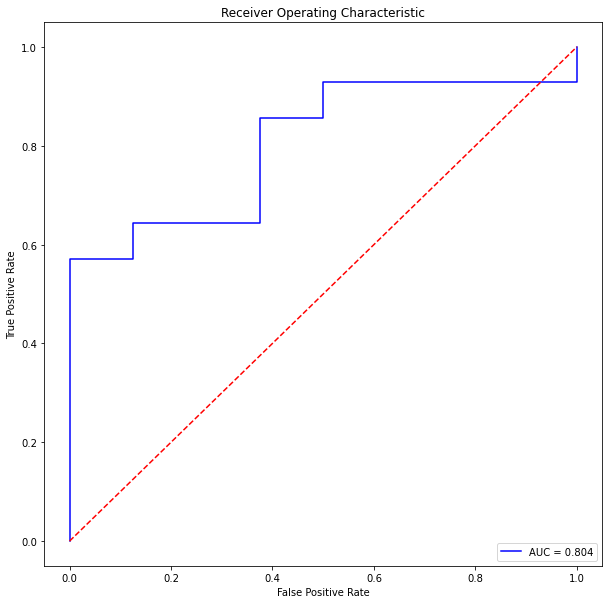

In [17]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

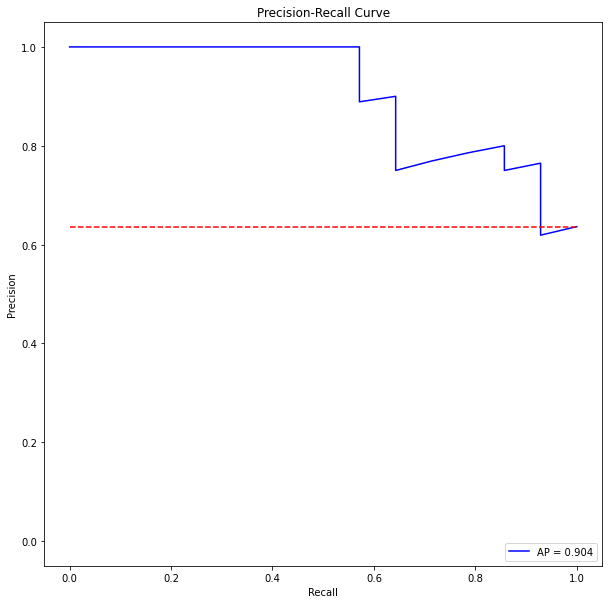

In [18]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

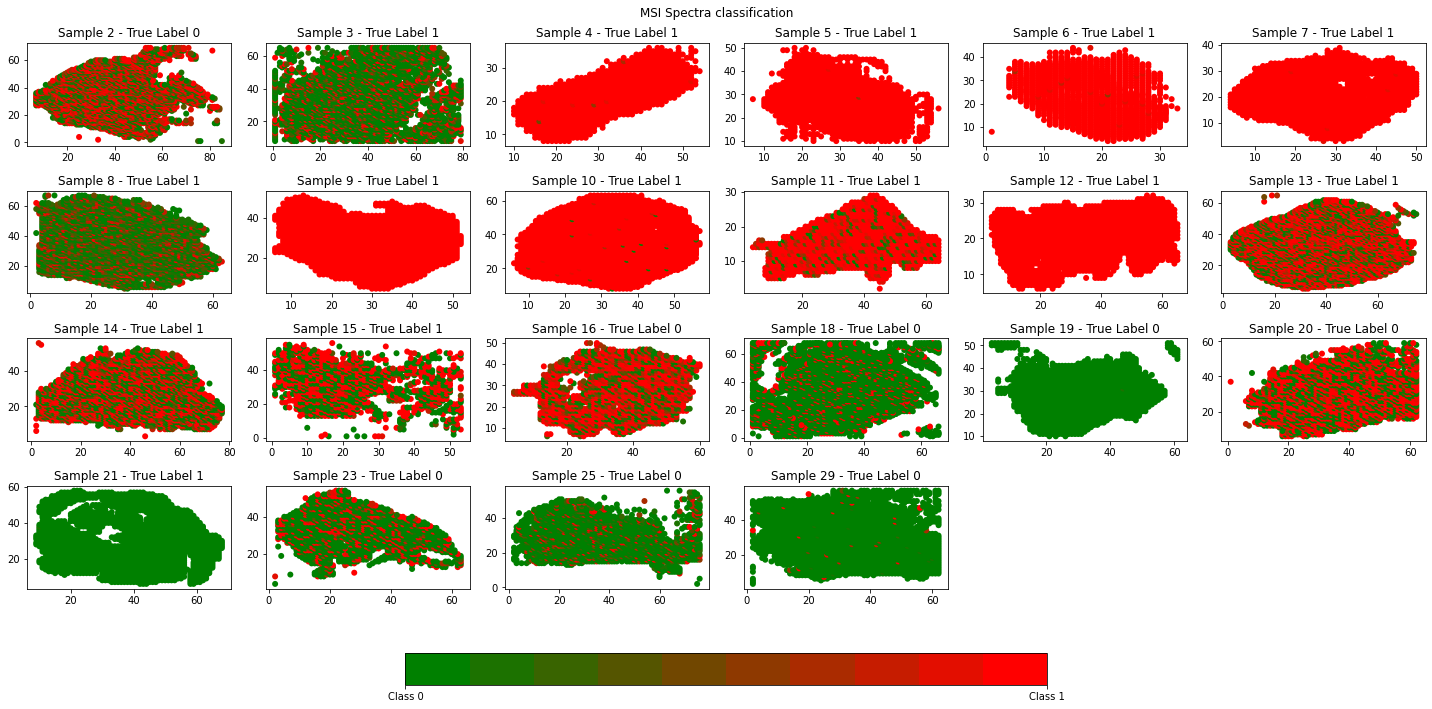

In [19]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [20]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:33<00:00,  4.26s/it]


Next, let's get some statistics about each left out sample predictions:

In [21]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.0000000004,1.0000000000,0.9992115498,0.9490647912,0.1722276211,0,1
1,3,0.0000064682,0.9999881983,0.4006886482,0.4567158818,0.3853315711,1,0
2,4,0.9619653225,0.9999980927,0.9999260902,0.9997385144,0.0014514375,1,1
3,5,0.9857642055,0.9999998808,0.9999867678,0.9999021888,0.0005780814,1,1
4,6,0.0054155714,0.9977759719,0.6612626910,0.6013335586,0.3027558327,1,1
5,7,0.2126726210,0.9999399185,0.9897350073,0.9651342034,0.0693399981,1,1
6,8,0.0002359670,0.9999998808,0.9797394872,0.8557844758,0.2475916892,1,1
7,9,0.7249332666,0.9999997616,0.9999648333,0.9985918403,0.0105623333,1,1
8,10,0.0001315626,0.9999992847,0.9939515591,0.8817033768,0.2461436242,1,1
9,11,0.0000250267,0.9836720824,0.0049213008,0.0885890648,0.1968238205,1,0


Next, let's evaluate the classification performance:

In [22]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.636
Balanced  Accuracy: 0.634
Precision: 0.750
Recall: 0.643
F1 score: 0.692


Next, let's plot the roc curve:

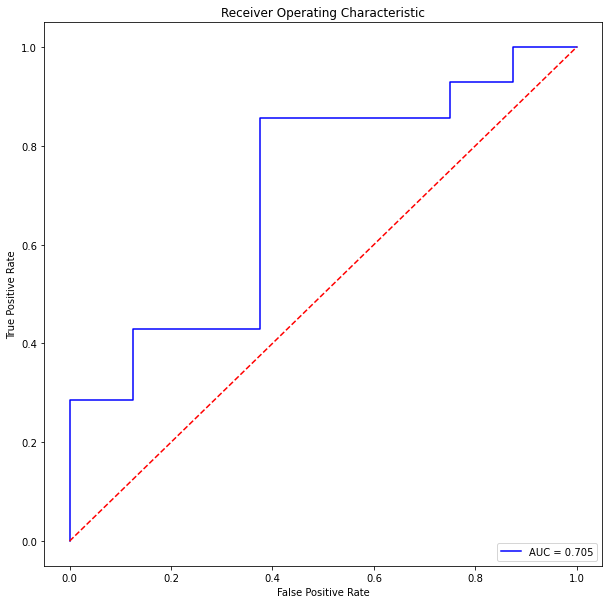

In [23]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

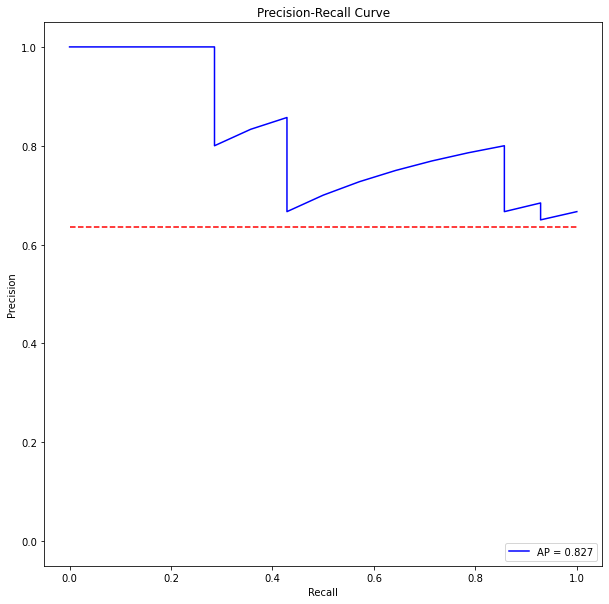

In [24]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

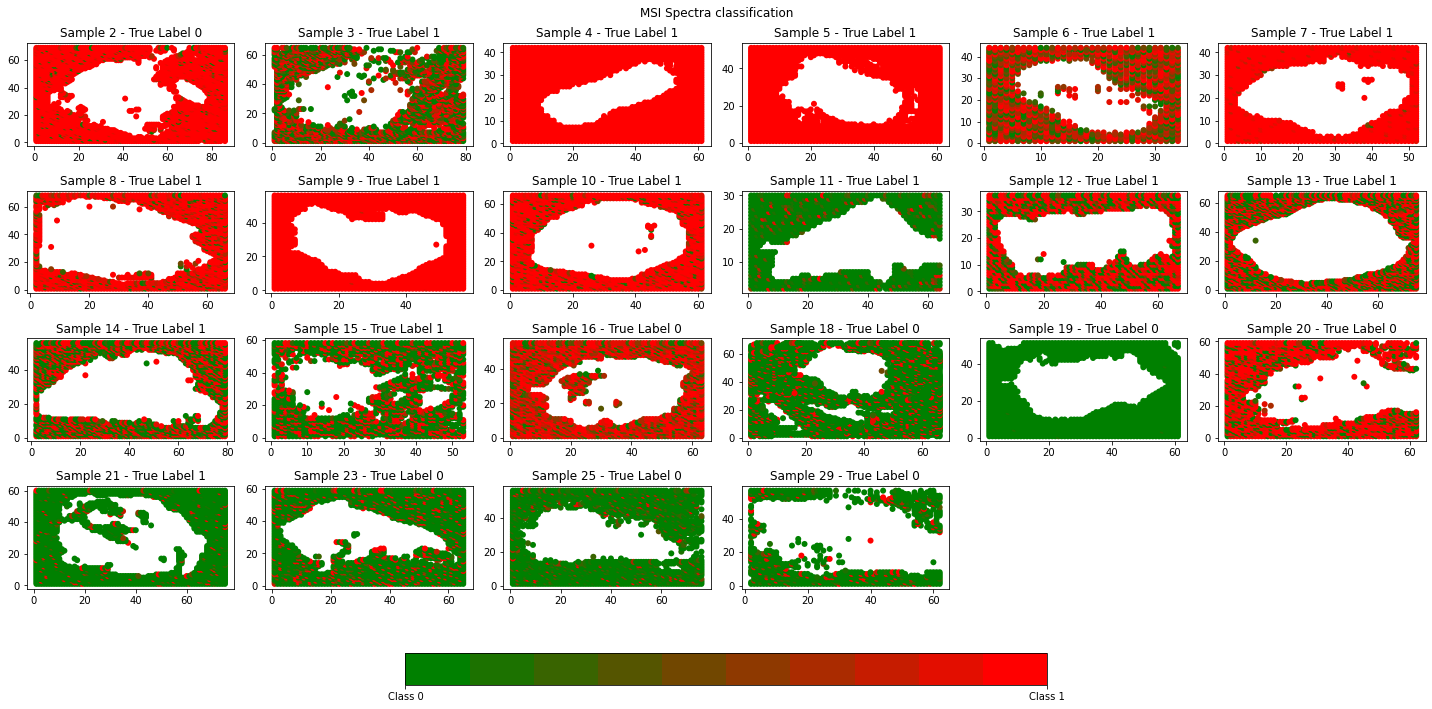

In [25]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [26]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()